<a href="https://colab.research.google.com/github/cgihlstorf/AIAgents/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
!pip install transformers torch datasets accelerate tqdm bitsandbytes matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 34.4 MB/s eta 0:00:00


In [3]:
!pip install -U bitsandbytes

In [15]:
output_dir = "drive/MyDrive/UVA/Courses/Spring 2026/Workshop on Building AI Agents/hw1_outputs/output_files_10_subjects"

In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform
from torch.profiler import profile, ProfilerActivity

In [17]:
def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"



def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)

            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True,
            )


        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True,
                )

            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True,
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True,
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print("Exception:", e)
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")

def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer



def evaluate_subject(model, tokenizer, subject, verbose:bool=False):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    ground_truth_answers = []
    model_answers = []

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

        ground_truth_answers.append(correct_answer)
        model_answers.append(predicted_answer)

        if verbose:
            print("Question:", question)
            print("Model Answer:", predicted_answer)
            correctness_bool = (predicted_answer == correct_answer)
            correctness_str = "Correct" if correctness_bool else f'Incorrect (correct answer is {correct_answer})'
            print("Correctness:", correctness_str)
            print("=" * 70)

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy,
        "ground_truth_answers": ground_truth_answers,
        "model_answers": model_answers,
    }


In [18]:
def main(verbose:bool=False):
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()
    cpu_duration = None
    gpu_duration = None

    if USE_GPU == False:
        activities = [ProfilerActivity.CPU]

    else:
        if device == "cuda":
            activities = [ProfilerActivity.CUDA]
        else:
            raise ValueError("GPU must use CUDA")


    with profile(activities=activities) as prof:
      for i, subject in enumerate(MMLU_SUBJECTS, 1):
          print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
          result = evaluate_subject(model, tokenizer, subject, verbose=verbose)
          if result:
              results.append(result)
              total_correct += result["correct"]
              total_questions += result["total"]

    prof_str = str(prof.key_averages())
    cpu_duration = prof_str.split("Self CPU time total:")[1].split("Self CUDA time total:")[0].replace(" ", "").strip()

    if USE_GPU == True:
      gpu_duration = prof_str.split("Self CUDA time total:")[1].replace(" ", "").strip()

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()


    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"{output_dir}/{model_name_short}_results{quant_suffix}_{device}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "cpu_duration" : cpu_duration,
        "gpu_duration" : gpu_duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file

In [30]:
# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

#MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"
#MODEL_NAME = "allenai/OLMo-2-0425-1B-SFT"
#MODEL_NAME = "Qwen/Qwen2.5-0.5B"

#MODEL_NAME = "meta-llama/Llama-3.1-8B"
#MODEL_NAME = "allenai/OLMo-2-1124-7B"
MODEL_NAME = "Qwen/Qwen2.5-7B"

model_name_short = MODEL_NAME.split("/")[1]


# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = None  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]

In [31]:
main()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âœ“ GPU Available: NVIDIA A100-SXM4-80GB
âœ“ GPU Memory: 85.17 GB
âœ“ Quantization disabled - loading full precision model
âœ“ Hugging Face authenticated

Configuration
Model: Qwen/Qwen2.5-7B
Device: cuda
Quantization: None (full precision)
Expected memory: ~2.5 GB (FP16)
Number of subjects: 10


Loading model Qwen/Qwen2.5-7B...
Device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

âœ“ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

âœ“ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 15.24 GB allocated, 17.38 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

âœ“ Result: 119/152 correct = 78.29%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 74/100 correct = 74.00%

Progress: 3/10 subjects

Evaluating subject: nutrition


Testing nutrition:   0%|          | 0/306 [00:00<?, ?it/s]

âœ“ Result: 234/306 correct = 76.47%

Progress: 4/10 subjects

Evaluating subject: philosophy


Testing philosophy:   0%|          | 0/311 [00:00<?, ?it/s]

âœ“ Result: 233/311 correct = 74.92%

Progress: 5/10 subjects

Evaluating subject: prehistory


Testing prehistory:   0%|          | 0/324 [00:00<?, ?it/s]

âœ“ Result: 260/324 correct = 80.25%

Progress: 6/10 subjects

Evaluating subject: professional_accounting


Testing professional_accounting:   0%|          | 0/282 [00:00<?, ?it/s]

âœ“ Result: 153/282 correct = 54.26%

Progress: 7/10 subjects

Evaluating subject: public_relations


Testing public_relations:   0%|          | 0/110 [00:00<?, ?it/s]

âœ“ Result: 73/110 correct = 66.36%

Progress: 8/10 subjects

Evaluating subject: security_studies


Testing security_studies:   0%|          | 0/245 [00:00<?, ?it/s]

âœ“ Result: 184/245 correct = 75.10%

Progress: 9/10 subjects

Evaluating subject: sociology


Testing sociology:   0%|          | 0/201 [00:00<?, ?it/s]

âœ“ Result: 173/201 correct = 86.07%

Progress: 10/10 subjects

Evaluating subject: us_foreign_policy


Testing us_foreign_policy:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 89/100 correct = 89.00%

EVALUATION SUMMARY
Model: Qwen/Qwen2.5-7B
None (full precision)
Total Subjects: 10
Total Questions: 2131
Total Correct: 1592
Overall Accuracy: 74.71%
Duration: 11.2 minutes

âœ“ Results saved to: drive/MyDrive/UVA/Courses/Spring 2026/Workshop on Building AI Agents/hw1_outputs/output_files_10_subjects/Qwen2.5-7B_results_full_cuda_20260118_021429.json

ðŸ“Š Top 5 Subjects:
  1. us_foreign_policy: 89.00%
  2. sociology: 86.07%
  3. prehistory: 80.25%
  4. astronomy: 78.29%
  5. nutrition: 76.47%

ðŸ“‰ Bottom 5 Subjects:
  1. security_studies: 75.10%
  2. philosophy: 74.92%
  3. business_ethics: 74.00%
  4. public_relations: 66.36%
  5. professional_accounting: 54.26%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('drive/MyDrive/UVA/Courses/Spring 2026/Workshop on Building AI Agents/hw1_outputs/output_files_10_subjects/Qwen2.5-7B_results_full_cuda_20260118_021429.json')

âœ… Evaluation complete!


'drive/MyDrive/UVA/Courses/Spring 2026/Workshop on Building AI Agents/hw1_outputs/output_files_10_subjects/Qwen2.5-7B_results_full_cuda_20260118_021429.json'

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

In [45]:
figures_dir = "drive/MyDrive/UVA/Courses/Spring 2026/Workshop on Building AI Agents/hw1_outputs/figures"

In [66]:
def make_plots(file_paths:list, output_file_name:str):

    answer_matrix = [[0 for _ in file_paths] for _ in file_paths] #make an nxn matrix for a heatmap
    heatmap_dict = {}

    models = []
    subjects = []
    accs = []

    for file_path in file_paths:

        file_path_items = file_path.replace(f'{output_dir}/', "").split("_")
        model_name = file_path_items[0]
        quant_config = file_path_items[2]
        architecture = file_path_items[3]

        file = open(file_path, 'r')
        file_string = file.read()
        file_dict = json.loads(file_string)

        subject_results = file_dict["subject_results"]

        for subject_dict in subject_results:

            subject = subject_dict["subject"]
            accuracy = subject_dict["accuracy"]
            ground_truth_answers = subject_dict["ground_truth_answers"]
            model_answers = subject_dict["model_answers"]

            models.append(model_name)
            subjects.append(subject)
            accs.append(accuracy)

            if subject not in heatmap_dict.keys():
                heatmap_dict[subject] = {}

            heatmap_dict[subject][model_name] = model_answers #TODO check



    for subject in heatmap_dict.keys():

        subject_dict = heatmap_dict[subject]
        heatmap_models = []

        for i in range(len(list(subject_dict.keys()))):

            model_1 = list(subject_dict.keys())[i]
            m1_answers = subject_dict[model_1]
            heatmap_models.append(model_1)

            for j in range(len(list(subject_dict.keys()))):

                model_2 = list(subject_dict.keys())[j]
                m2_answers = subject_dict[model_2]

                overlap = compute_overlap(m1_answers, m2_answers)
                answer_matrix[i][j] = overlap

        plt.figure(figsize=(15, 14))
        heatmap = sns.heatmap(np.array(answer_matrix), xticklabels=heatmap_models, yticklabels=heatmap_models, annot=True)
        plt.title(f'{subject} {output_file_name}')
        plt.savefig(f'{figures_dir}/{output_file_name}_{subject}_heatmap.png')



    accuracy_df = pd.DataFrame({
        "Model" : models,
        "Subject" : subjects,
        "Accuracy" : accs,
    })


    plt.figure(figsize=(12, 10))
    acc_barplot = sns.barplot(accuracy_df, x="Model", y="Accuracy", hue="Subject")
    acc_barplot.tick_params("x", rotation=45)
    plt.title(f'MMLU Results {output_file_name}')
    plt.savefig(f'{figures_dir}/{output_file_name}_accuracies.png')


def choose_files(output_dir:str, by_model:bool=False, model:str=None, by_quant:bool=False, quant:str=None, by_architecture:bool=False, architecture:str=None):

        model_specs = []

        if by_model:
            assert model != None
            model_specs.append(model)
        if by_quant:
            assert quant != None
            model_specs.append(quant)
        if by_architecture:
            assert architecture != None
            model_specs.append(architecture)

        model_substr = "_" + "_".join(model_specs) + "_"
        print(model_substr)

        found_files = []

        for root, dirs, files in os.walk(output_dir):
            for file_name in files:
                if model_substr in file_name:
                    found_files.append(f'{output_dir}/' + file_name)

        return found_files, model_substr[1:-1]


def compute_overlap(lst1, lst2):

    assert len(lst1) == len(lst2)

    total_items = len(lst1)
    matching_items = 0

    for i1, i2 in zip(lst1, lst2):
        if i1 == i2:
            matching_items += 1

    return matching_items / total_items





In [67]:
def plot_main():
  file_paths, output_file_name = choose_files(output_dir, by_quant=True, quant="full", by_architecture=True, architecture="cuda")
  make_plots(file_paths, output_file_name)

_full_cuda_


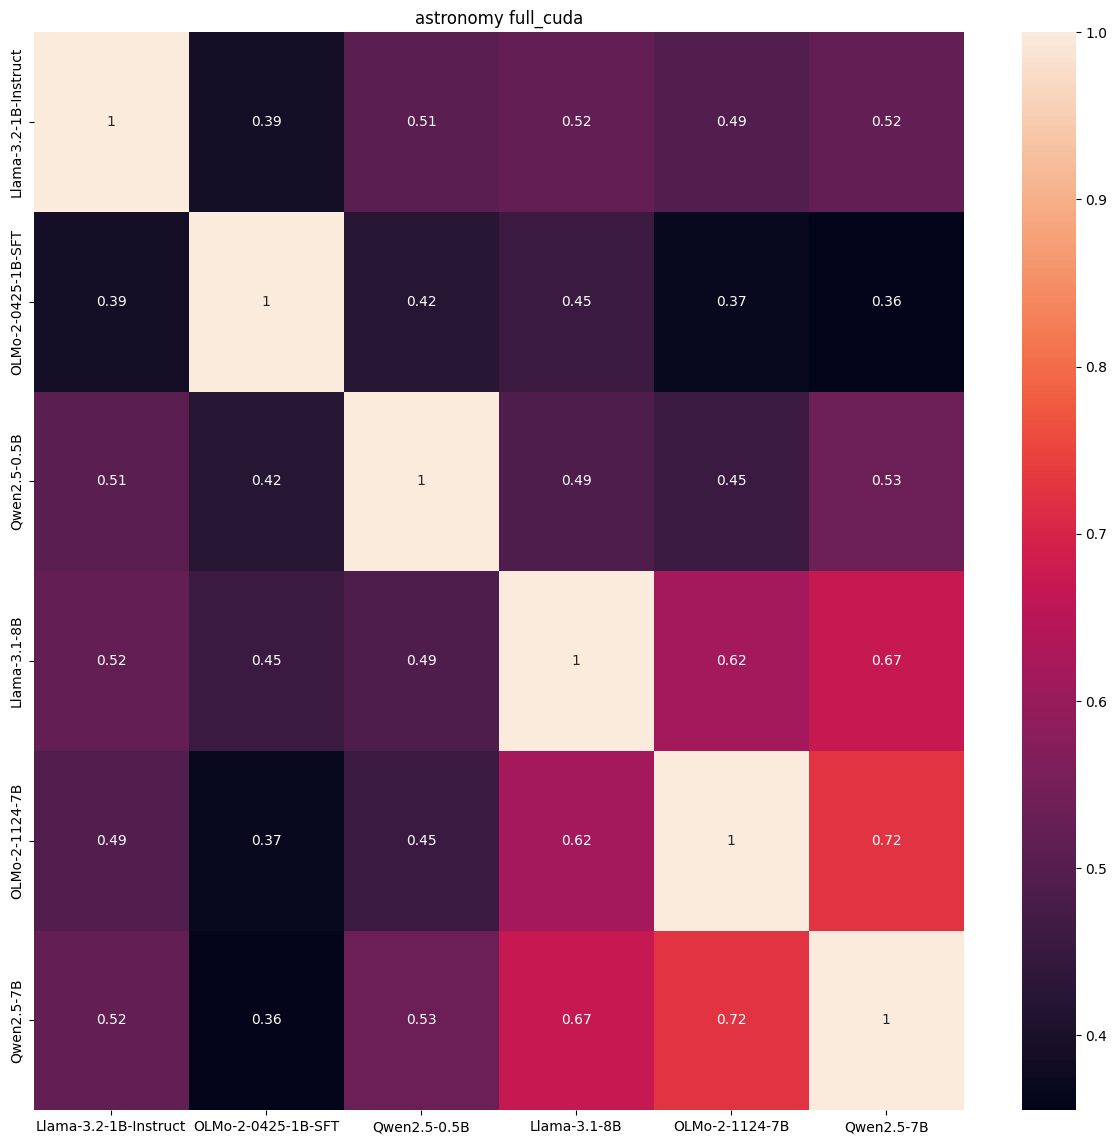

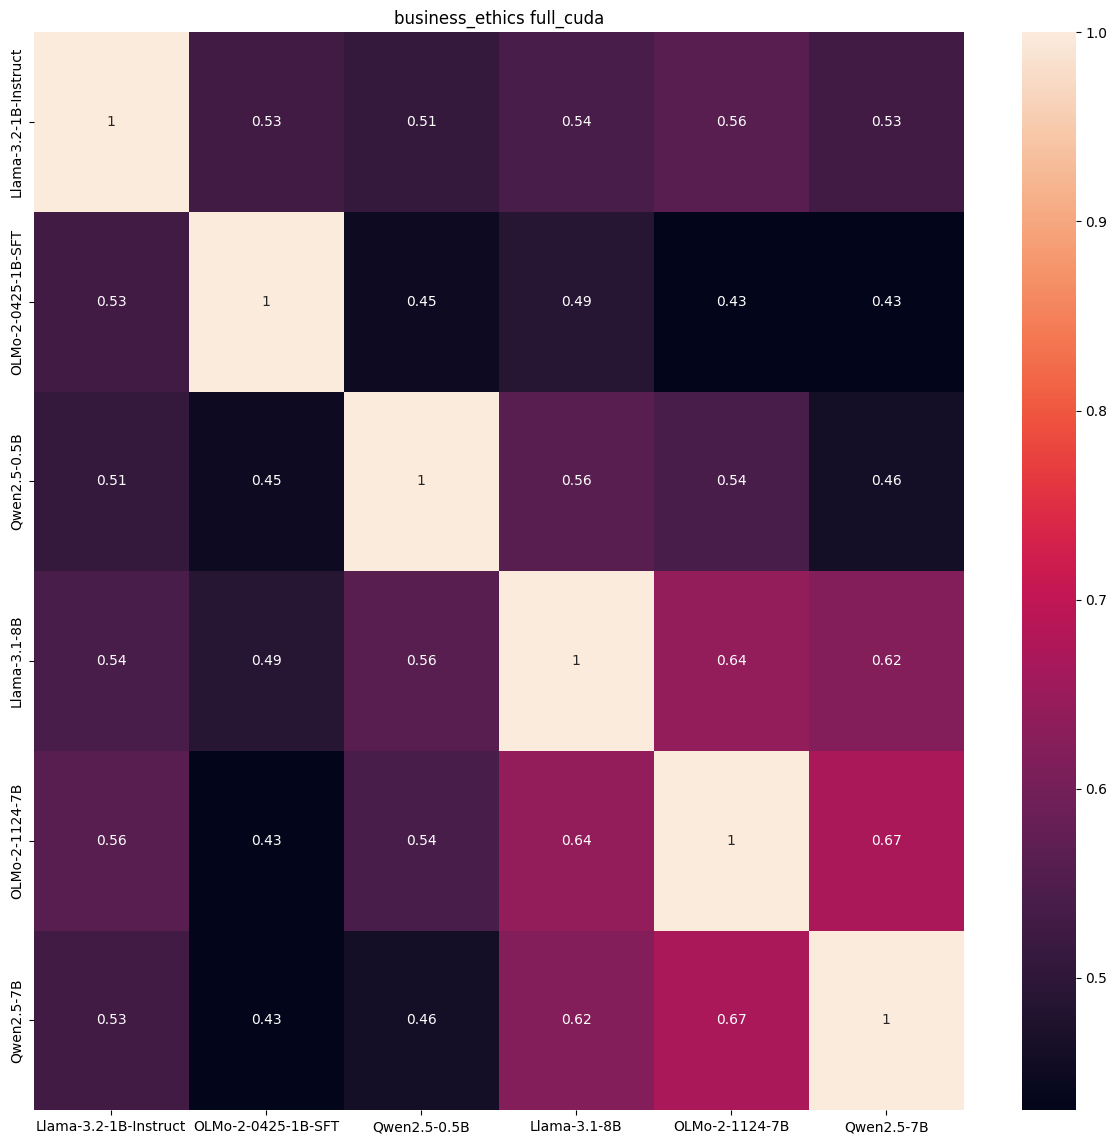

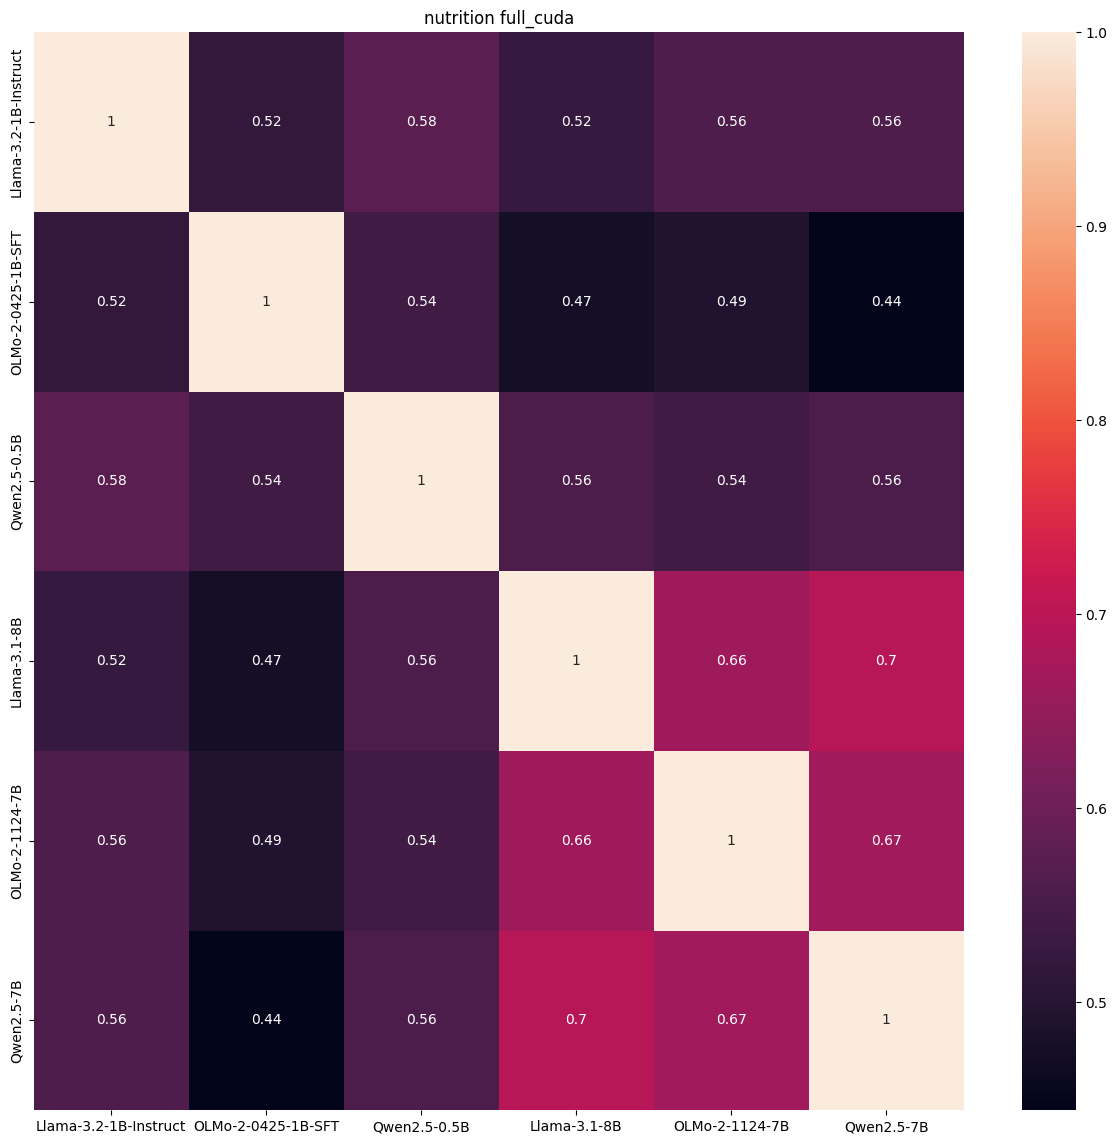

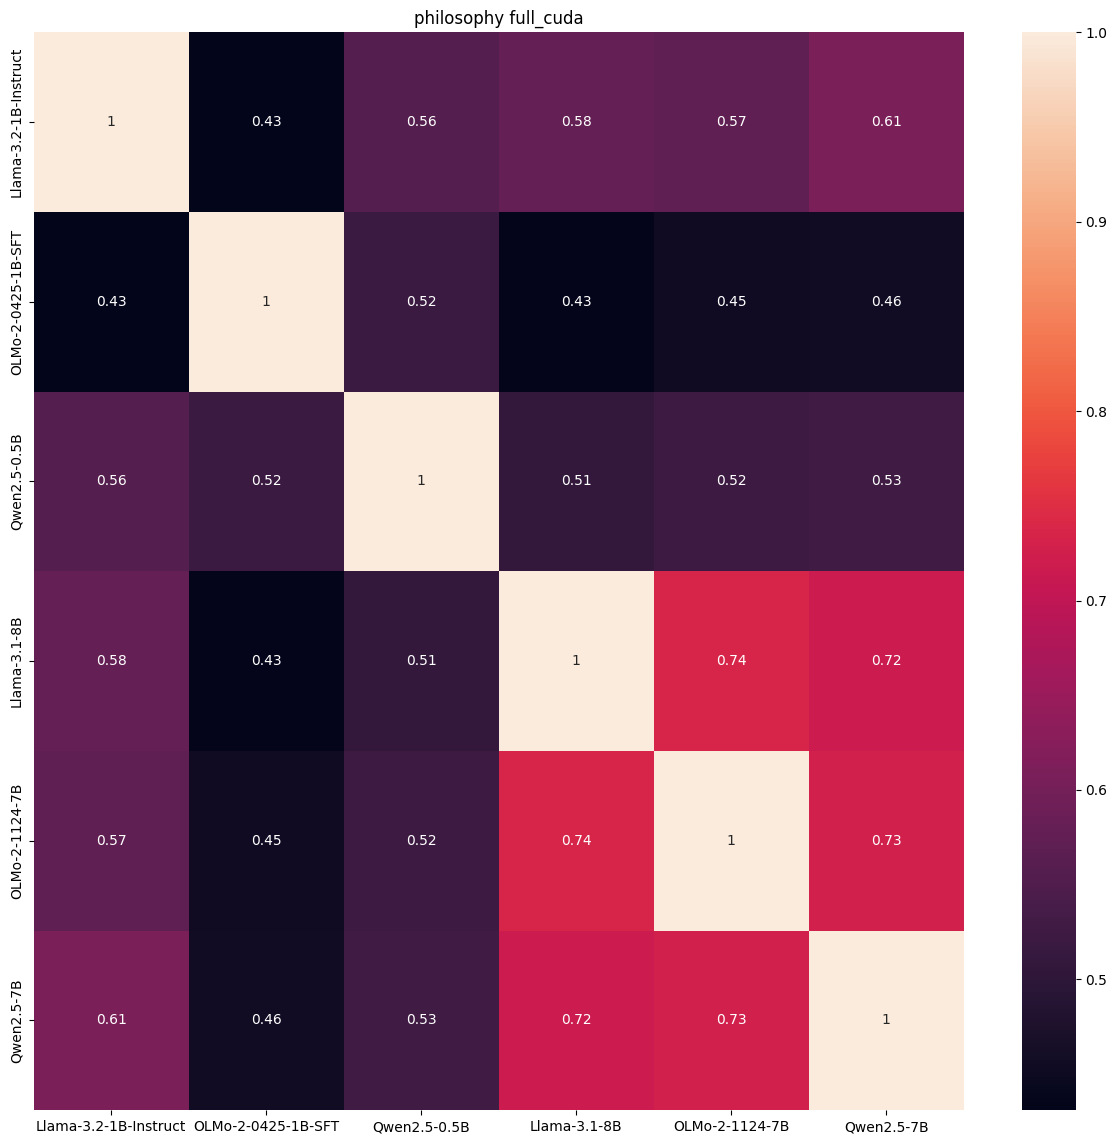

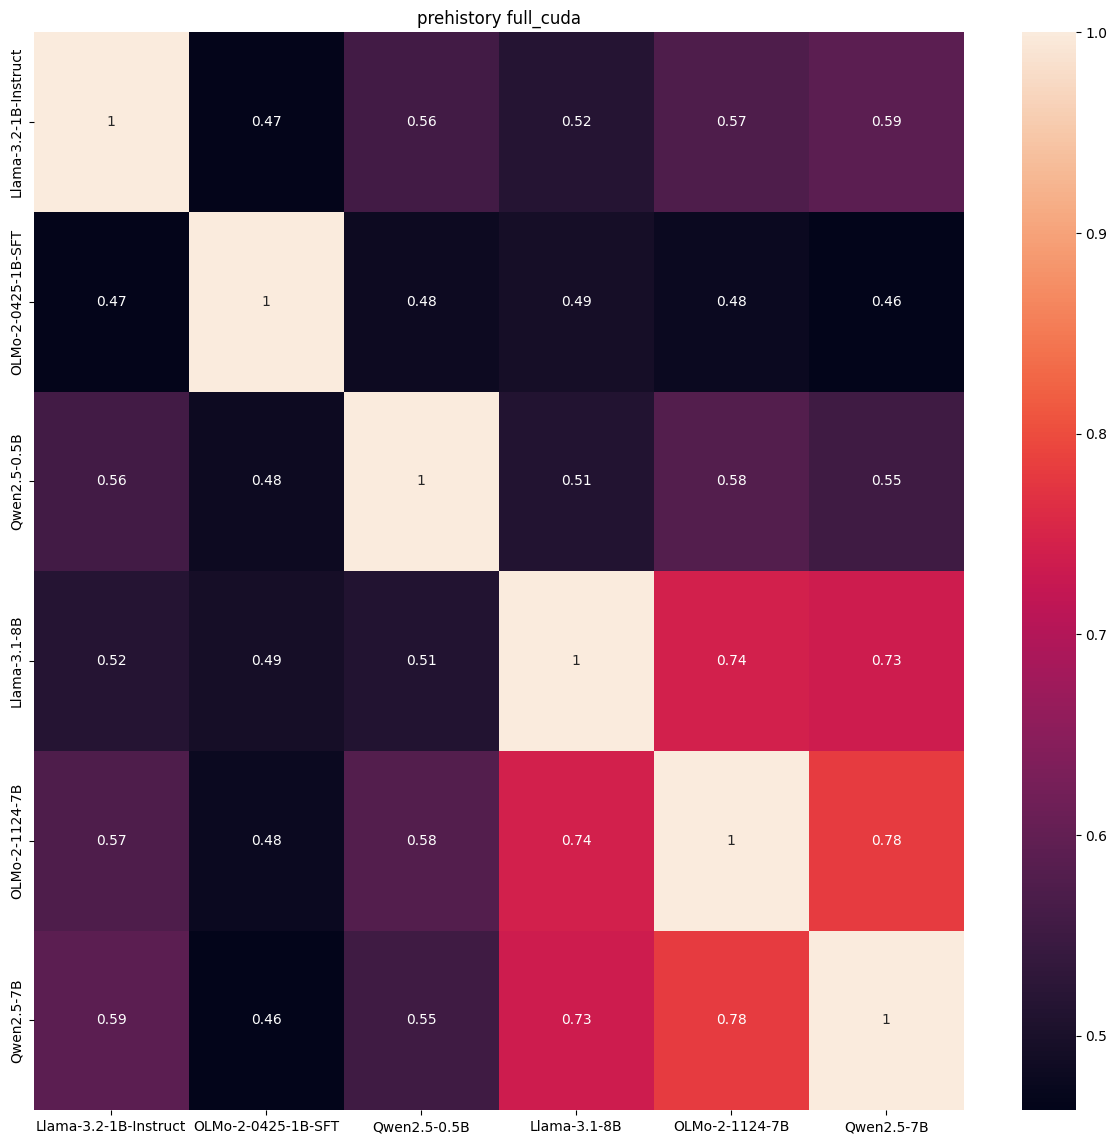

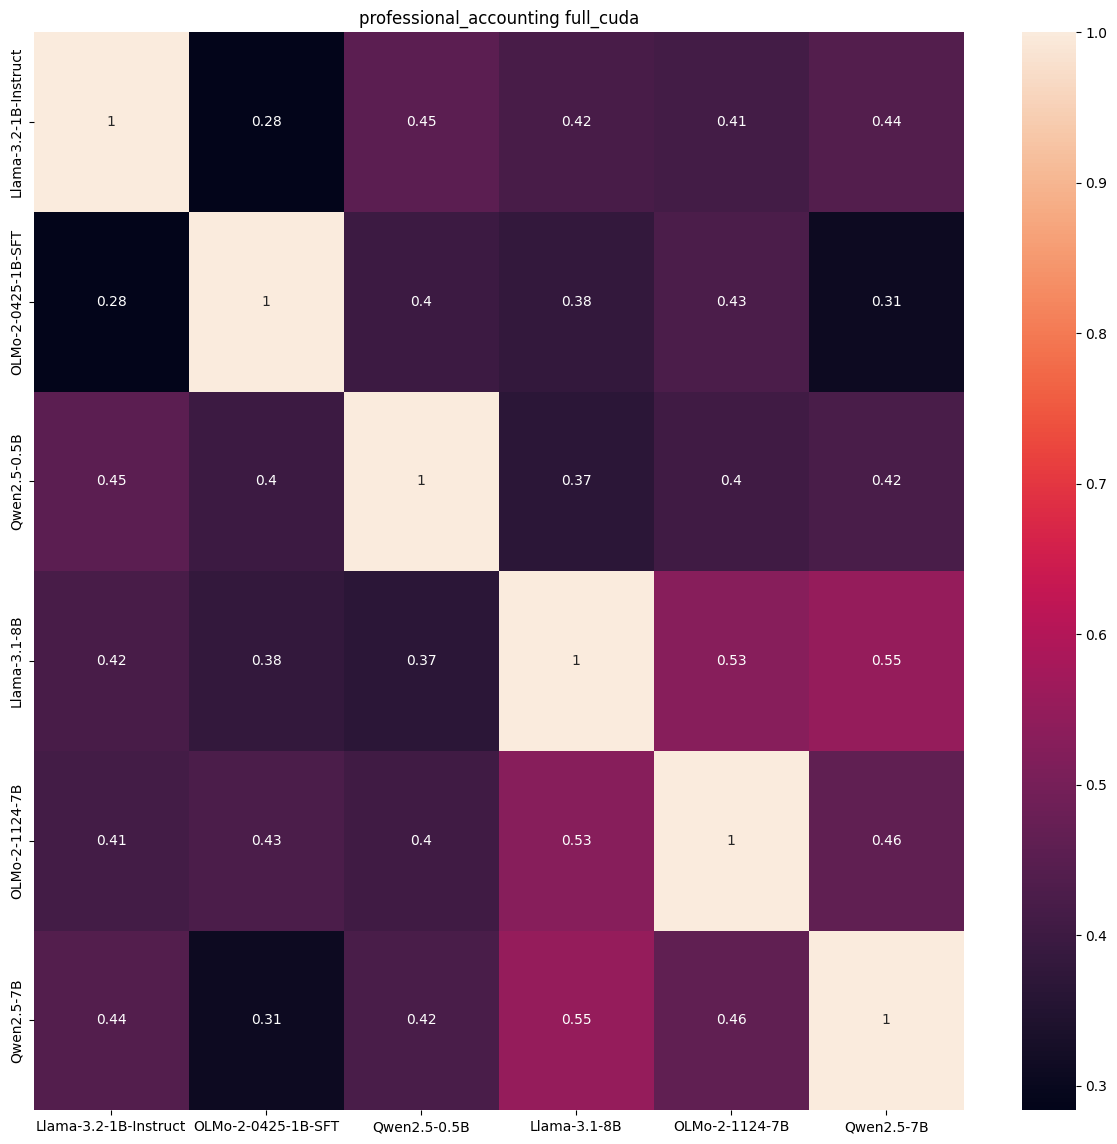

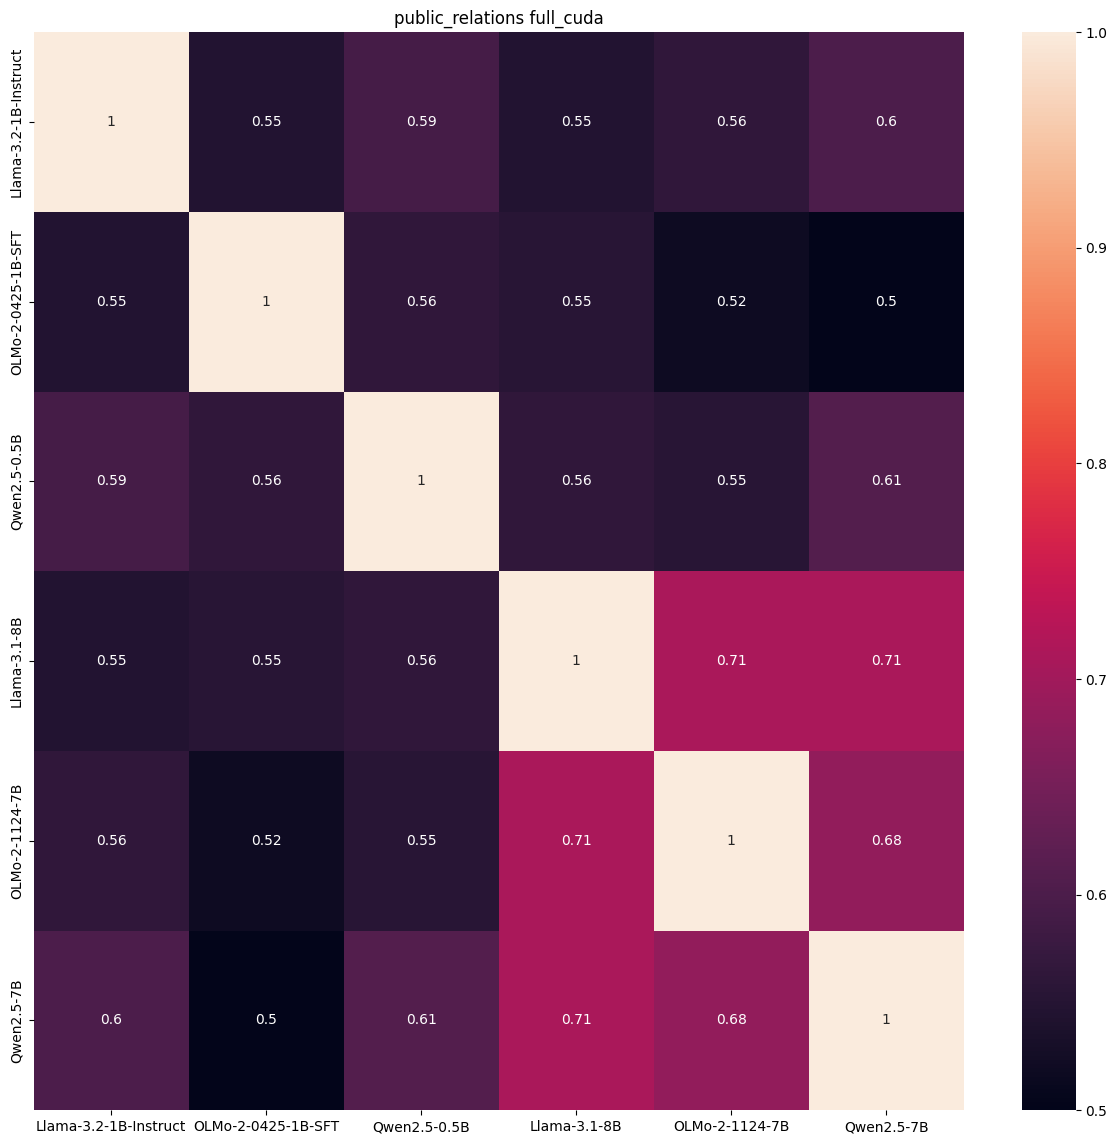

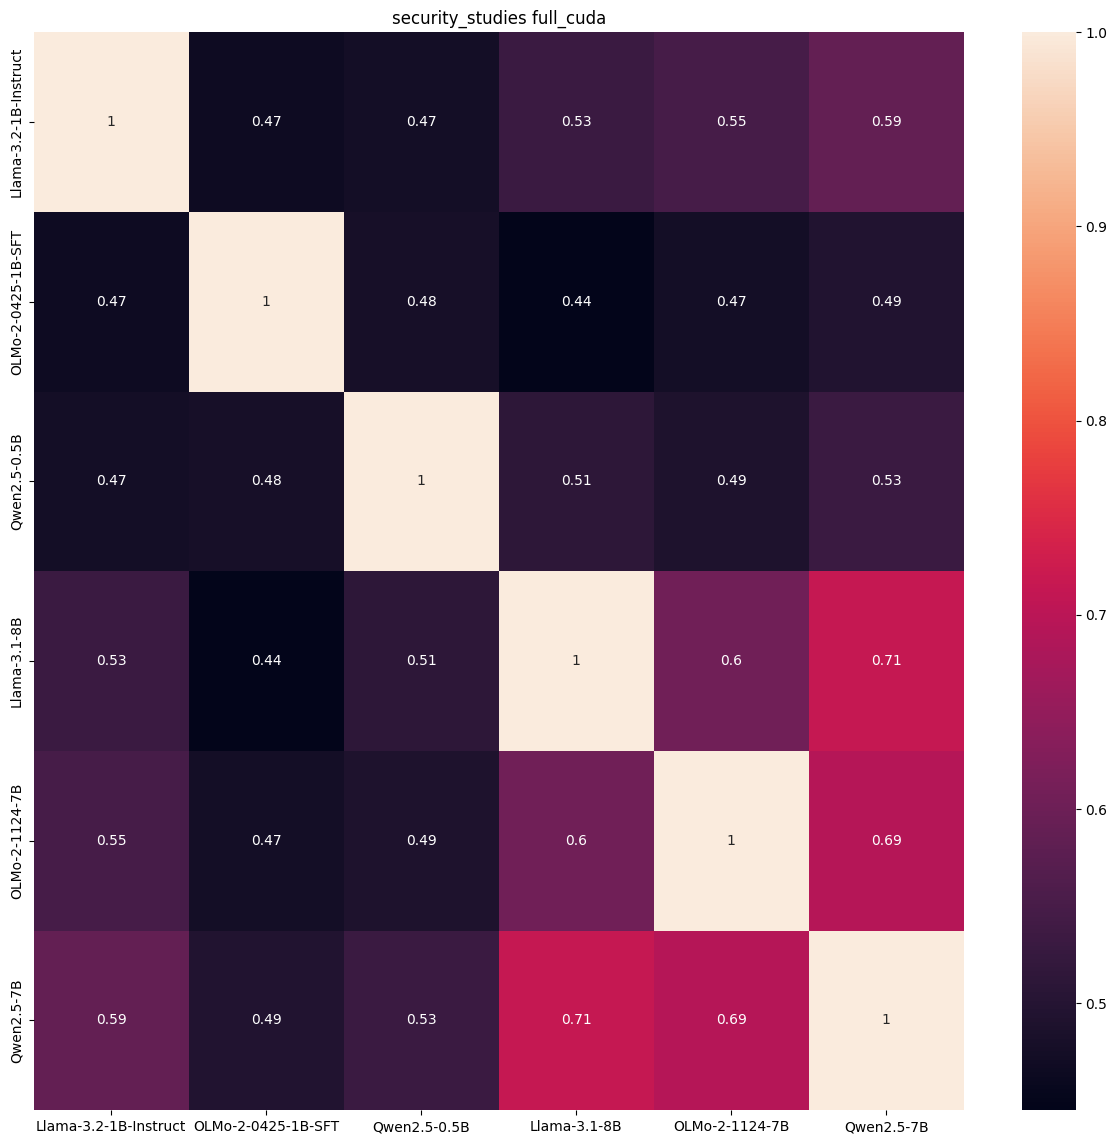

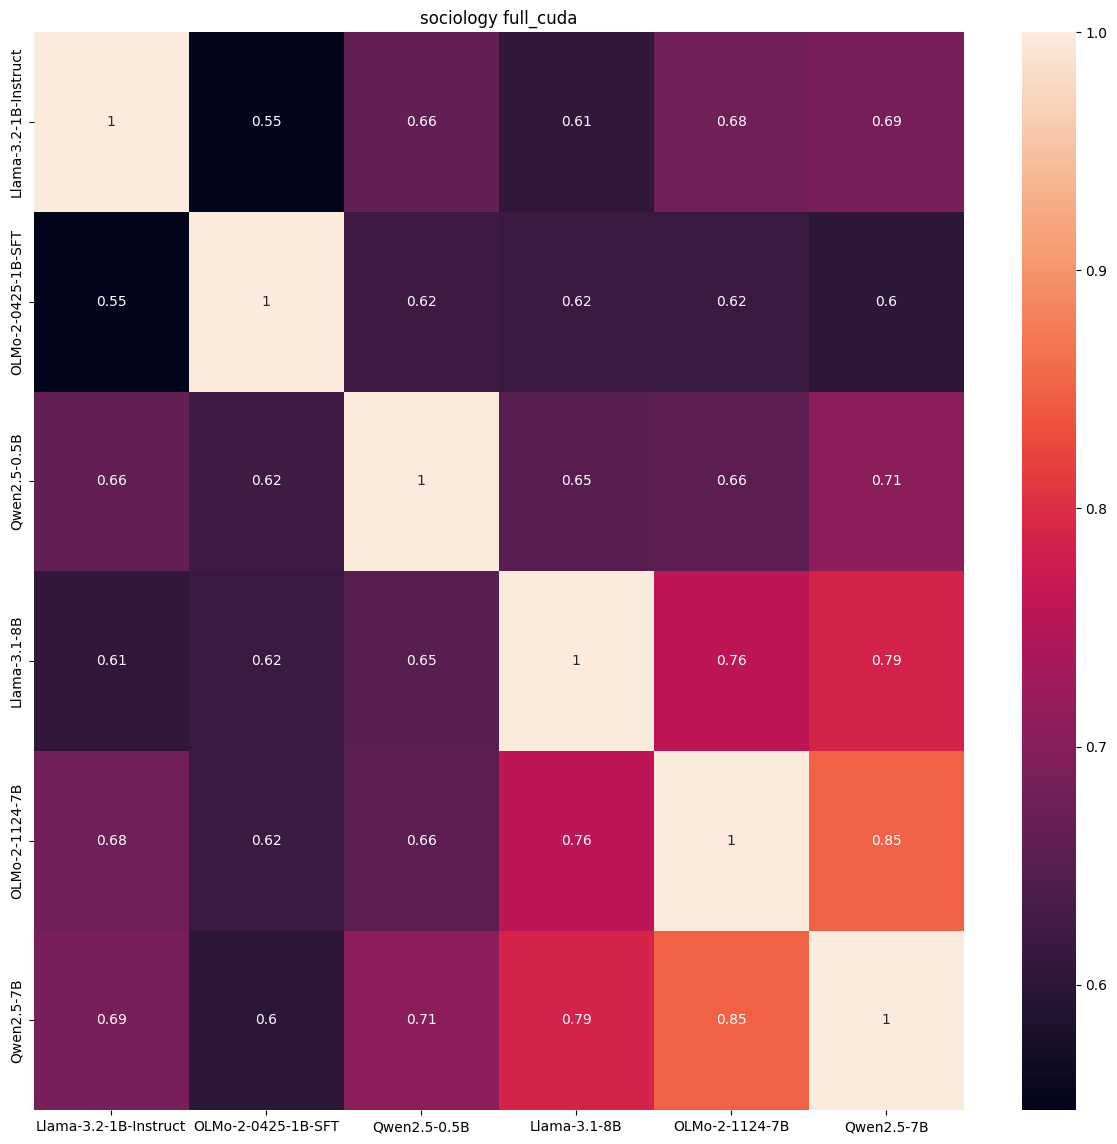

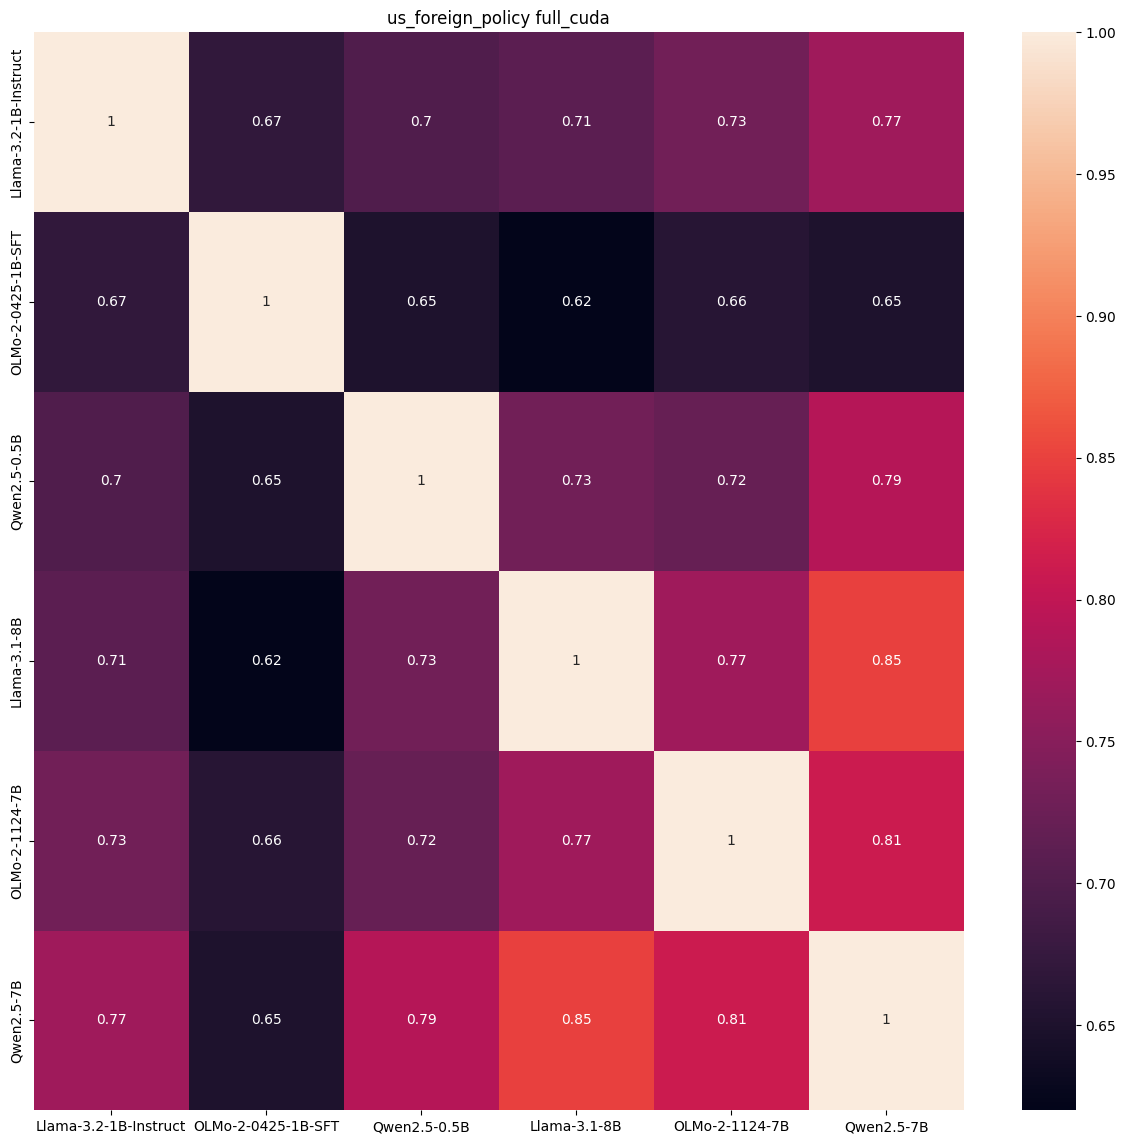

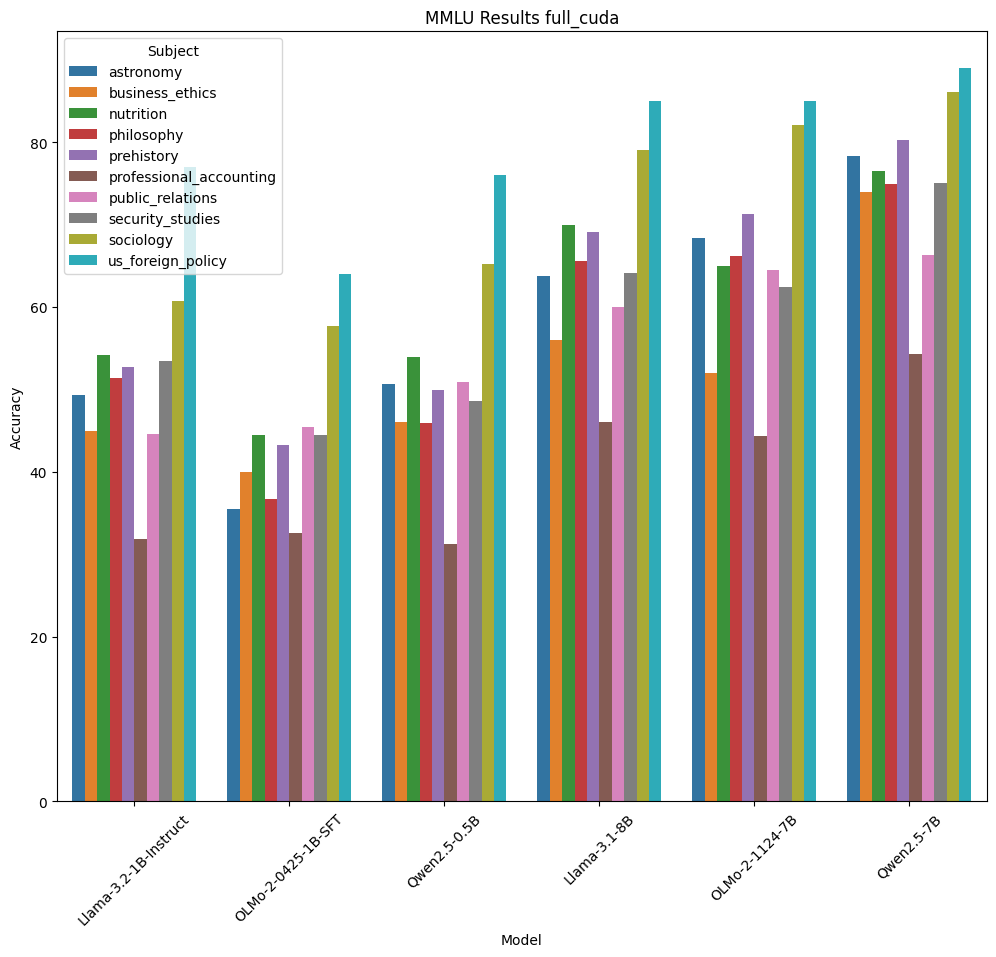

In [68]:
plot_main()

/content
